# Instacart Market Basket Analysis Exploratory Data Analysis

### By Philip Sparks

In [1]:
# Import the neccessary modules for data manipulation and visual representation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

#### From GitHub, these descriptions will help with wrangling the data into the correct format for discovery and analysis.

`orders` (3.4m rows, 206k users):
* `order_id`: order identifier
* `user_id`: customer identifier
* `eval_set`: which evaluation set this order belongs in (see `SET` described below)
* `order_number`: the order sequence number for this user (1 = first, n = nth)
* `order_dow`: the day of the week the order was placed on
* `order_hour_of_day`: the hour of the day the order was placed on
* `days_since_prior`: days since the last order, capped at 30 (with NAs for `order_number` = 1)

`products` (50k rows):
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

`aisles` (134 rows):
* `aisle_id`: aisle identifier
* `aisle`: the name of the aisle

`deptartments` (21 rows):
* `department_id`: department identifier
* `department`: the name of the department

`order_products__SET` (30m+ rows):
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

where `SET` is one of the four following evaluation sets (`eval_set` in `orders`):
* `"prior"`: orders prior to that users most recent order (~3.2m orders)
* `"train"`: training data supplied to participants (~131k orders)
* `"test"`: test data reserved for machine learning competitions (~75k orders)

### Convert all tables to the Pandas Data Frames we will eventually be working with.



In [2]:
aisles = pd.DataFrame.from_csv('instacart_2017_05_01/aisles.csv')

departments = pd.DataFrame.from_csv('instacart_2017_05_01/departments.csv')

order_products__priors = pd.DataFrame.from_csv('instacart_2017_05_01/order_products__prior.csv')

order_products__train = pd.DataFrame.from_csv('instacart_2017_05_01/order_products__train.csv')

orders = pd.DataFrame.from_csv('instacart_2017_05_01/orders.csv')

products = pd.DataFrame.from_csv('instacart_2017_05_01/products.csv')

### Check the heads of the data to see samples and confirm data is loaded.

In [3]:
aisles.head()

,aisle
aisle_id,
1,prepared soups salads
2,specialty cheeses
3,energy granola bars
4,instant foods
5,marinades meat preparation


In [4]:
departments.head()

,department
department_id,
1,frozen
2,other
3,bakery
4,produce
5,alcohol


In [5]:
order_products__priors.head(10)

,product_id,add_to_cart_order,reordered
order_id,,,
2,33120,1,1
2,28985,2,1
2,9327,3,0
2,45918,4,1
2,30035,5,0
2,17794,6,1
2,40141,7,1
2,1819,8,1
2,43668,9,0


In [6]:
order_products__train.head(10)

,product_id,add_to_cart_order,reordered
order_id,,,
1,49302,1,1
1,11109,2,1
1,10246,3,0
1,49683,4,0
1,43633,5,1
1,13176,6,0
1,47209,7,0
1,22035,8,1
36,39612,1,0


In [7]:
orders.sort_index().head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
1,112108,train,4,4,10,9.0
2,202279,prior,3,5,9,8.0
3,205970,prior,16,5,17,12.0
4,178520,prior,36,1,9,7.0
5,156122,prior,42,6,16,9.0


In [8]:
products.head(10)

,product_name,aisle_id,department_id
product_id,,,
1,Chocolate Sandwich Cookies,61,19
2,All-Seasons Salt,104,13
3,Robust Golden Unsweetened Oolong Tea,94,7
4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
5,Green Chile Anytime Sauce,5,13
6,Dry Nose Oil,11,11
7,Pure Coconut Water With Orange,98,7
8,Cut Russet Potatoes Steam N' Mash,116,1
9,Light Strawberry Blueberry Yogurt,120,16


### Check for null values.

In [9]:
print aisles.isnull().any()
print departments.isnull().any()
print orders.isnull().any()
print products.isnull().any()

aisle    False
dtype: bool
department    False
dtype: bool
user_id                   False
eval_set                  False
order_number              False
order_dow                 False
order_hour_of_day         False
days_since_prior_order     True
dtype: bool
product_name     False
aisle_id         False
department_id    False
dtype: bool


### Determine the same with the product orders.

In [10]:
print order_products__priors.isnull().any()
print order_products__train.isnull().any()

product_id           False
add_to_cart_order    False
reordered            False
dtype: bool
product_id           False
add_to_cart_order    False
reordered            False
dtype: bool


### orders : days_since_prior_order has NaN. We'll change that to "0" to have numerical values throughout the set.

In [11]:
orders.fillna(value = 0).head(5)

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
2539329,1,prior,1,2,8,0.0
2398795,1,prior,2,3,7,15.0
473747,1,prior,3,3,12,21.0
2254736,1,prior,4,4,7,29.0
431534,1,prior,5,4,15,28.0


In [12]:
print orders.isnull().any()

user_id                   False
eval_set                  False
order_number              False
order_dow                 False
order_hour_of_day         False
days_since_prior_order     True
dtype: bool


In [13]:
#orders.describe()

### Append training and prior sets to create a data frame with all rows for merging.

In [14]:
orders_products_full = order_products__priors.append(order_products__train)

In [15]:
orders.sort_index().head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
1,112108,train,4,4,10,9.0
2,202279,prior,3,5,9,8.0
3,205970,prior,16,5,17,12.0
4,178520,prior,36,1,9,7.0
5,156122,prior,42,6,16,9.0


In [16]:
orders_products_full.sort_index().head()

,product_id,add_to_cart_order,reordered
order_id,,,
1,49302,1,1
1,10246,3,0
1,49683,4,0
1,43633,5,1
1,13176,6,0


### Merge the data frames into one for future EDA and analysis.

In [17]:
orders_join_1 = pd.merge(orders, orders_products_full, left_index = True, right_index = True, how = 'left')

In [18]:
orders_join_1.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
order_id,,,,,,,,,
1,112108,train,4,4,10,9.0,49302.0,1.0,1.0
1,112108,train,4,4,10,9.0,11109.0,2.0,1.0
1,112108,train,4,4,10,9.0,10246.0,3.0,0.0
1,112108,train,4,4,10,9.0,49683.0,4.0,0.0
1,112108,train,4,4,10,9.0,43633.0,5.0,1.0


In [19]:
orders_join_2 = pd.merge(orders_join_1, products, left_on = 'product_id', right_index = True, how = 'left')

In [20]:
orders_join_2.head(5)

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
order_id,,,,,,,,,,,,
1,112108,train,4,4,10,9.0,49302,1.0,1.0,Bulgarian Yogurt,120.0,16.0
1,112108,train,4,4,10,9.0,11109,2.0,1.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108.0,16.0
1,112108,train,4,4,10,9.0,10246,3.0,0.0,Organic Celery Hearts,83.0,4.0
1,112108,train,4,4,10,9.0,49683,4.0,0.0,Cucumber Kirby,83.0,4.0
1,112108,train,4,4,10,9.0,43633,5.0,1.0,Lightly Smoked Sardines in Olive Oil,95.0,15.0


In [21]:
aisles.head()

,aisle
aisle_id,
1,prepared soups salads
2,specialty cheeses
3,energy granola bars
4,instant foods
5,marinades meat preparation


In [22]:
orders_final = pd.merge(orders_join_2, aisles, left_on = 'aisle_id', right_index = True, how = 'left')

In [23]:
orders_final

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
order_id,,,,,,,,,,,,,
1,112108,train,4,4,10,9.0,49302,1.0,1.0,Bulgarian Yogurt,120,16.0,yogurt
1,112108,train,4,4,10,9.0,11109,2.0,1.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16.0,other creams cheeses
1,112108,train,4,4,10,9.0,10246,3.0,0.0,Organic Celery Hearts,83,4.0,fresh vegetables
1,112108,train,4,4,10,9.0,49683,4.0,0.0,Cucumber Kirby,83,4.0,fresh vegetables
1,112108,train,4,4,10,9.0,43633,5.0,1.0,Lightly Smoked Sardines in Olive Oil,95,15.0,canned meat seafood
1,112108,train,4,4,10,9.0,13176,6.0,0.0,Bag of Organic Bananas,24,4.0,fresh fruits
1,112108,train,4,4,10,9.0,47209,7.0,0.0,Organic Hass Avocado,24,4.0,fresh fruits
1,112108,train,4,4,10,9.0,22035,8.0,1.0,Organic Whole String Cheese,21,16.0,packaged cheese
2,202279,prior,3,5,9,8.0,33120,1.0,1.0,Organic Egg Whites,86,16.0,eggs


### Data Frames to use for EDA

In [24]:
#aisles
#departments
#order_products__priors
#order_products__train
#orders
#products
#orders_final

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
order_id,,,,,,,,,,,,,
1,112108,train,4,4,10,9.0,49302,1.0,1.0,Bulgarian Yogurt,120,16.0,yogurt
1,112108,train,4,4,10,9.0,11109,2.0,1.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16.0,other creams cheeses
1,112108,train,4,4,10,9.0,10246,3.0,0.0,Organic Celery Hearts,83,4.0,fresh vegetables
1,112108,train,4,4,10,9.0,49683,4.0,0.0,Cucumber Kirby,83,4.0,fresh vegetables
1,112108,train,4,4,10,9.0,43633,5.0,1.0,Lightly Smoked Sardines in Olive Oil,95,15.0,canned meat seafood
1,112108,train,4,4,10,9.0,13176,6.0,0.0,Bag of Organic Bananas,24,4.0,fresh fruits
1,112108,train,4,4,10,9.0,47209,7.0,0.0,Organic Hass Avocado,24,4.0,fresh fruits
1,112108,train,4,4,10,9.0,22035,8.0,1.0,Organic Whole String Cheese,21,16.0,packaged cheese
2,202279,prior,3,5,9,8.0,33120,1.0,1.0,Organic Egg Whites,86,16.0,eggs


In [25]:
orders_final.product_name.value_counts().head(25)

Banana                        491291
Bag of Organic Bananas        394930
Organic Strawberries          275577
Organic Baby Spinach          251705
Organic Hass Avocado          220877
Organic Avocado               184224
Large Lemon                   160792
Strawberries                  149445
Limes                         146660
Organic Whole Milk            142813
Organic Raspberries           142603
Organic Yellow Onion          117716
Organic Garlic                113936
Organic Zucchini              109412
Organic Blueberries           105026
Cucumber Kirby                 99728
Organic Fuji Apple             92889
Organic Lemon                  91251
Organic Grape Tomatoes         88078
Apple Honeycrisp Organic       87272
Seedless Red Grapes            86748
Organic Cucumber               85005
Honeycrisp Apple               83320
Organic Baby Carrots           80493
Sparkling Water Grapefruit     79245
Name: product_name, dtype: int64

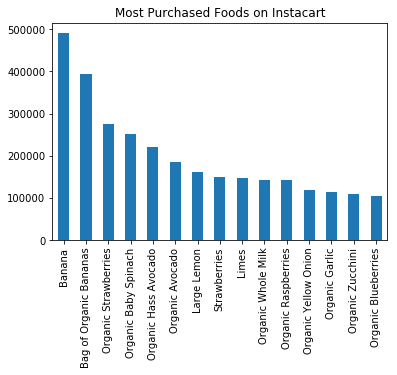

In [26]:
orders_final.product_name.value_counts().head(15).plot(kind = 'bar', title = 'Most Purchased Foods on Instacart')

In [46]:
orders_final.order_dow.value_counts().sort_index()

0    6549360
1    5882935
2    4387546
3    4007383
4    3951864
5    4396423
6    4718595
Name: order_dow, dtype: int64

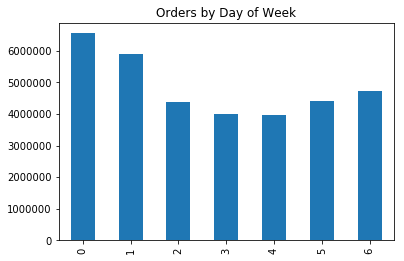

In [45]:
orders_final.order_dow.value_counts().sort_index().plot(kind = 'bar', title = 'Orders by Day of Week')

In [42]:
orders_final.order_hour_of_day.value_counts().sort_index()

0      228565
1      121707
2       72824
3       53890
4       55848
5       92104
6      303258
7      930075
8     1790896
9     2555852
10    2880853
11    2858813
12    2738612
13    2784168
14    2817301
15    2787163
16    2653804
17    2191771
18    1718801
19    1320804
20    1020163
21     832806
22     663539
23     420489
Name: order_hour_of_day, dtype: int64

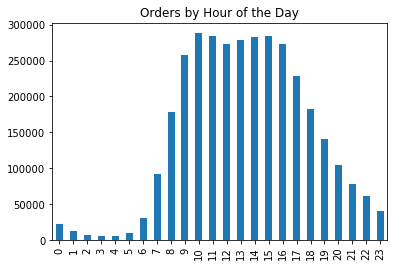

In [43]:
orders.order_hour_of_day.value_counts().sort_index().plot(kind = 'bar', title = 'Orders by Hour of the Day')

In [47]:
orders.days_since_prior_order.value_counts().sort_index()

0.0      67755
1.0     145247
2.0     193206
3.0     217005
4.0     221696
5.0     214503
6.0     240013
7.0     320608
8.0     181717
9.0     118188
10.0     95186
11.0     80970
12.0     76146
13.0     83214
14.0    100230
15.0     66579
16.0     46941
17.0     39245
18.0     35881
19.0     34384
20.0     38527
21.0     45470
22.0     32012
23.0     23885
24.0     20712
25.0     19234
26.0     19016
27.0     22013
28.0     26777
29.0     19191
30.0    369323
Name: days_since_prior_order, dtype: int64

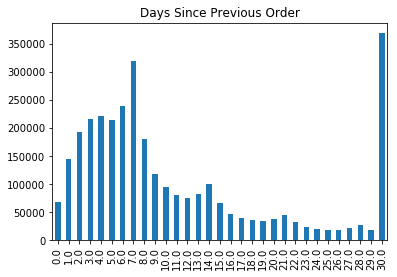

In [48]:
orders.days_since_prior_order.value_counts().sort_index().plot(kind = 'bar', title = 'Days Since Previous Order')